In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BÃ¼hler for this suggestion

TRAIN_DIR = "/media/ghost/BA5A944C5A9406F3/ecr_data/train"
TEST_DIR = '/media/ghost/BA5A944C5A9406F3/ecr_data/test'
# TRAIN_DIR = '/media/ghost/BA5A944C5A9406F3/dataset/dataset_ecr/train'
# TEST_DIR = '/media/ghost/BA5A944C5A9406F3/dataset/dataset_ecr/test'
# TEST_DIR = '/home/ghost/Documents/BIRDS'
# TEST_DIR = '/home/ghost/Desktop/test'
IMG_SIZE1 =175
IMG_SIZE2 =140
LR = 1e-4

MODEL_NAME = 'ECR-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [2]:
MODEL_NAME

'ECR-0.0001-2conv-basic.model'

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [explicit,normal]
    #                            [much explicit, no normal]
    if word_label == 'pos': return [1,0]
    #                             [no explicit, very normal]
    elif word_label == 'neg': return [0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE1,IMG_SIZE2))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('/media/ghost/BA5A944C5A9406F3/ecr_data/train_data.npy', training_data)
    return training_data

In [1]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE1,IMG_SIZE2))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('/media/ghost/BA5A944C5A9406F3/ecr_data/test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = create_train_data()
# If you have already created the dataset:
# train_data = np.load('/media/ghost/BA5A944C5A9406F3/ecr_data/train_data.npy')

Convolutional Neural Network

Next, we're ready to define our neural network:


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected, flatten
from tflearn.layers.estimator import regression

In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
convnet = input_data(shape=[None, IMG_SIZE1, IMG_SIZE2, 1], 
                     name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = dropout(convnet, 0.3)
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = dropout(convnet, 0.3)
convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = dropout(convnet, 0.3)
convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = conv_2d(convnet, 128, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)
convnet = flatten(convnet)

convnet = fully_connected(convnet, 256, activation='relu')
convnet = dropout(convnet, 0.3)

convnet = fully_connected(convnet, 512, activation='relu')
convnet = dropout(convnet, 0.3)

convnet = fully_connected(convnet, 1024, activation='relu')

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', 
                     learning_rate=LR, 
                     loss='binary_crossentropy', 
                     name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-1000]
test = train_data[-1000:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE1,IMG_SIZE2,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE1,IMG_SIZE2,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 52209  | total loss: 0.57454 | time: 683.819s
| Adam | epoch: 003 | loss: 0.57454 - acc: 0.8575 -- iter: 28992/29000
Training Step: 52210  | total loss: 0.56962 | time: 691.591s
| Adam | epoch: 003 | loss: 0.56962 - acc: 0.8671 | val_loss: 0.56535 - val_acc: 0.8720 -- iter: 29000/29000
--


In [10]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/ghost/Documents/ecrn/ECR-0.0001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


Visually inspecting our network against unlabeled data

[  6.41015649e-22   1.00000000e+00]
[  9.98525298e-15   1.00000000e+00]
[  2.25603024e-14   1.00000000e+00]
[  9.21444887e-13   1.00000000e+00]
[  6.81964522e-15   1.00000000e+00]
[  1.96042153e-17   1.00000000e+00]
[  3.31276571e-17   1.00000000e+00]
[  1.47359785e-07   9.99999881e-01]
[  6.43562814e-10   1.00000000e+00]
[  1.34070977e-12   1.00000000e+00]
[  1.29563599e-17   1.00000000e+00]
[  1.18193953e-14   1.00000000e+00]


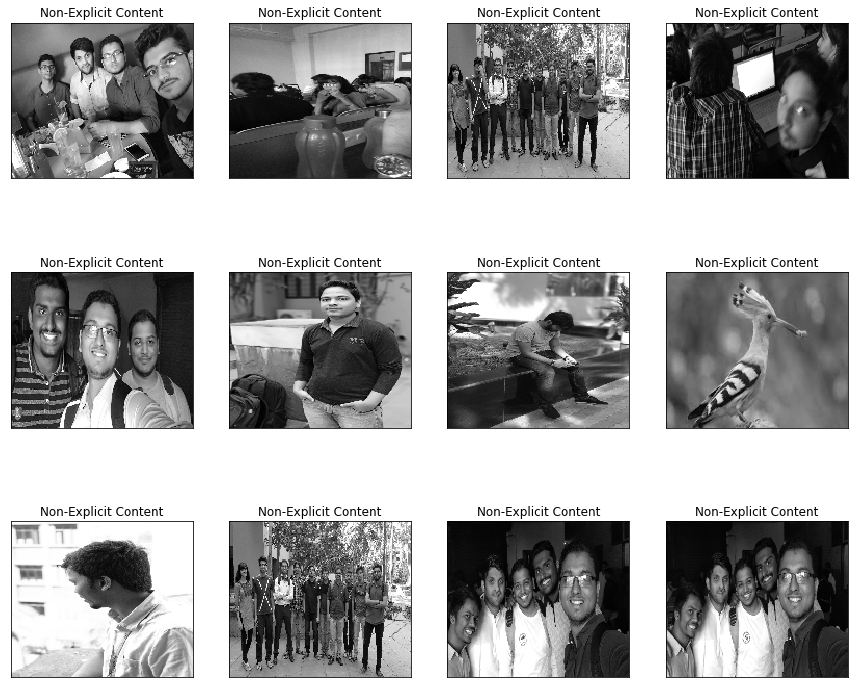

In [11]:
import matplotlib.pyplot as plt

# if you need to create the data:
# test_data = process_test_data()
# if you already have some saved:
test_data = np.load('/media/ghost/BA5A944C5A9406F3/ecr_data/test_data.npy')
plt.rcParams['figure.figsize'] = (15.0, 13.0)
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # explicit: [1,0]
    # normal: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE1,IMG_SIZE2,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    print(model_out)
    
    if np.argmax(model_out) == 1: str_label='Non-Explicit Content'
    else: str_label='Explicit Content'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()